# S-wave scattering phase shifts for an attractive square-well potential

In [1]:
from scipy.integrate import odeint
from scipy.special import struve
from scipy.special import yn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.dpi'] = 120
np.seterr(divide='ignore', invalid='ignore') # divide by zero? :D

mu = 1
R = 1
# R_max = 10

r = np.linspace(0, 5, 1024)
k = np.linspace(0, 5, 1024)


def square_well(r, V_0):
    # define Square well potential with adjustable depth V_0
    V_sw = - V_0 * np.heaviside(R-r, 0)
    return V_sw

def E_k(k):
    # kinetic energy considering units of hbar=1
    E = k**2 / (2 * mu)
    return E

def delta_0(k, V_0):
    arg = np.sqrt(E_k(k) / (E_k(k) + V_0)) * np.tan(R * np.sqrt(2 * mu * (E_k(k) + V_0)))
    delta_0 = np.arctan(arg) - R * np.sqrt(2 * mu * E_k(k))
    return delta_0

In [3]:
# plt.plot(k, delta_0(k, 0.5))
# plt.ylabel(r'$\delta_{0}(K)$')
# plt.xlabel(r'$k$')
# plt.show()

In [4]:
# another phase shift "stepyness" FIX
# k Cot(\delta_0(k))
# plt.figure(figsize=(4,2.7))
# plt.plot(k, k / np.tan(phase_0(k, 0.5)))
# plt.ylabel(r'$ k Cot(\delta_{0}(K))$',size=10)
# plt.xlabel(r'$k$',size=10)
# plt.show()

There are multiple methods used to remedy this discontinuous behaviour.
### Variable Phase Approach

Nonlinear ODE used in VPA: 
$\delta_\rho'(r) = -\frac{2 \mu sin^{2}(\delta_\rho +k r)}{k}$ with IC: $\delta_\rho = 0$

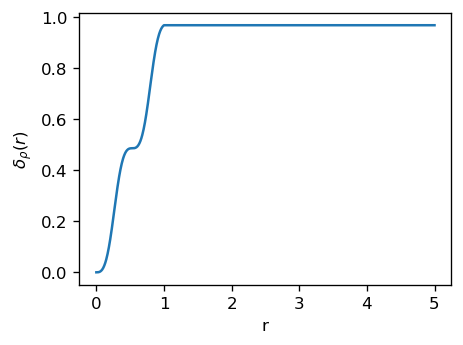

In [5]:
def ODE(delta_rho, r, k, V_0):
    top = 2 * mu * square_well(r, V_0) * np.sin(k * r + delta_rho)**2
    ddeltarho_dr = -(top/k)
    return ddeltarho_dr
                                 
# solve ODE from VPA
delta_rho = odeint(ODE, 0, r, args=(5, 5))
# print(delta_rho)

# plot results
plt.figure(figsize=(4,3))
plt.plot(r,delta_rho)
plt.xlabel('r')
plt.ylabel(r'$\delta_\rho(r)$')
plt.show()

# Trying out different well depths 
(Based on scatteringprimer.pdf ch.2).

$\ell = 0$ phase shift $\delta_0$ (in radians) for square well with 
$ m = \hbar = R = 1$ 

For $V_0$, versus energy $E = \frac{\hbar^2 k^2}{2m}$.
where $V_0 = [0.25, 0.5, 1.0, 1.5, ...]$

In [6]:
# analytic phase shift using arctan(tan((\delta_0(k))))
# v_0 = [0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
# for i in v_0:
#     linei, = plt.plot(k, np.arctan(np.tan(delta_0(k, i))), label=f"$V_0 = {i}$")
#     plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

# plt.ylim(-2, 2)
# plt.xlim(0, 5)
# plt.ylabel(r'$\delta_\rho(r)$')
# plt.xlabel(r'$E$',size=14)
# plt.show()

Notice that $V_0$ increases, a bound state appears.
and as one goes from V_0 = 1 to V 0 = 1.5,  the phase shift becomes negative.
The apparent discontinuity in the phase shift for V 0 = 1.5 is really just an ambiguity in angle: here $\delta$ is restricted to be between $−\pi$ and $+\pi$ radians.
Because of this ambiguity, it is sometimes convenient to plot 
$k cot(\delta_0)$

### How do you explain the results in terms of Levinson's theorem?

# IV Electron-exciton scattering
### (Schmidt et al.)

We want to compare  the resulting phase shifts for $MoS_2$ in the energy range $ 0 \leq E \leq 60 meV$
to <br>equation (7) **the universal low-energy behaviour of s-wave phase shifts in two dimensional systems**. 
    $$ cot(\delta) \approx \pi^{-1} ln(\frac{E}{E_1})$$

The energy scale $E_1$ defines the 2D scattering length $a_{2D}$ if a weakly bound state (BS) exists in the spectrum close to the exciton-electron scattering threshold, $E_1$ agrees with its binding energy. 

In [7]:
# parameters from table 1.
angstrom = 1e-10
r_0 = 44.6814 * angstrom # [m]
mass_e = 9.10938356e-31 # [kg]
mass_eff_e = 0.47 * mass_e 
mass_eff_h = 0.54  * mass_e
mass_X = mass_eff_e + mass_eff_h
M_red = mass_eff_e * mass_X / (mass_eff_e + mass_X) 

# parameters in table 2
eV = 1.602176634e-19 # [eV]
meV = 1e-3 * eV
r_star = 34 * angstrom
v_0 = -58.5 * meV

# E_1 = 1 / (2 * M_red * (a_2D)**2) # what is a_2D ???

def keldysh(r):
    # equation (2)
    V_K = (np.pi / (2 * r_0) * (special.struve(0, r/r_0) - special.yn(0, r/ r_0)))
    return V_K

def potential_Xe(r):
    # equation (8)
    if r <= r_star:
        V_Xe = v_0
    else:
         V_Xe = - (alpha / 2) * (keldysh(r).diff(r))**2 # WHAT IS ALPHA ???
    return V_Xe

In [8]:
# plt.plot(k, np.log(E(k)/ E_1) / np.pi)
# plt.ylabel(r'$pprox cot(\delta)$')
# plt.xlabel(r'$E$',size=14)
# plt.show()

we can interpret the y-intercept and slope of $k cot(\delta_0)$ in terms of fundamental quantities called the **scattering length** and **effective range**. Again, as the y-intercept passes through zero, we see that this corresponds to a bound state.

#### why are bound states closer the deeper the well is?